In [1]:
import torch 
import torch.nn as nn
import torchvision 

device = "cuda"
testset = torchvision.datasets.CIFAR10(root = "untracked",
                                        train = False, 
                                        download=True)

/home/bumjin/anaconda3/envs/deeping/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


170499072it [03:33, 798627.33it/s]                                


Extracting untracked/cifar-10-python.tar.gz to untracked


In [2]:
from lrp_module import LRP

# --- model ---
model = torchvision.models.vgg16(pretrained=True)
model.to(device)

# ---- manual ---
layers = [] 
rules = []
for layer in model.features:
    layers.append(layer)
    rules.append({"z_plus":True, "epsilon":1e-7})

layers.append(model.avgpool)
rules.append({"z_plus":True, "epsilon":1e-7})
layers.append(nn.Flatten(start_dim=1))
rules.append({"z_plus":True, "epsilon":1e-7})

for layer in model.classifier:
    layers.append(layer)
    rules.append({"z_plus":False, "epsilon":1e-7})


# ---- LRP object ---
# ImageNet
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
mean = torch.FloatTensor(MEAN).reshape(1,-1,1,1).cuda()
std = torch.FloatTensor(STD).reshape(1,-1,1,1).cuda()

lrp_model = LRP(layers, rules, device=device, mean=mean, std=std)


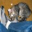

In [14]:
img = testset[0][0]
img

In [15]:
from torchvision import transforms
preprocess = transforms.Compose([
                            # transforms.ToPILImage(),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=MEAN, std=STD),    
                        ])
x = preprocess(img).unsqueeze(0)
output = lrp_model.forward(x.to(device))

In [16]:
output.keys()

dict_keys(['R', 'all_relevnaces', 'activations', 'prediction_outcome'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 32])


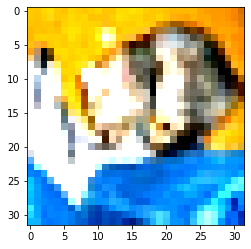

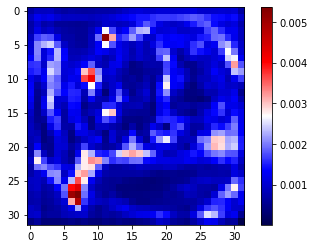

In [20]:
import matplotlib.pyplot as plt 
print(output['R'].size())
plt.figure()
plt.imshow(x.squeeze(0).permute(1,2,0))
plt.figure()
plt.imshow(output['R'].squeeze(0).sum(0).cpu().detach(), cmap="seismic")
plt.colorbar()